In [11]:
# ver. 5.0
# Delete the code which will drop the columns that std == 0

# ver. 6.0
# Make the PEOE_VSA descriptors as one feature with multiple lists and fr_ descriptors as another feature with multiple lists

# ver. 7.0
# Delete the one set feature update

# ver. 8.0
# Add the semi-supervised learning

# ver. 8.1
# Change the feature selector strategy

# ver. 8.2
# Add the hyperparameter tuning

# ver. 9.0
# Remove the semi-supervied learning

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import shap

from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor

#from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold
#from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV

from statistics import mean, stdev

from joblib import dump, load
import os

shap.initjs()
os.makedirs('models', exist_ok=True)

In [55]:
dataset = pd.read_csv("240627Zeta.csv")


columns_to_drop = ["ref", "Sample", "Smiles"]
for column in columns_to_drop:
    if column in dataset:
        dataset = dataset.drop(column, axis=1)
        

In [56]:
labeled_data = dataset

# Label
zeta = labeled_data.filter(regex="Zeta")

# Features
df_raw = labeled_data.drop("Zeta potential / mV", axis=1)
max_abs_scaler = MaxAbsScaler()
max_abs_scaler.fit(df_raw)
df_scaled = max_abs_scaler.transform(df_raw)
descriptors = pd.DataFrame(df_scaled, columns=df_raw.columns)
dataset = pd.concat([zeta, descriptors], axis = 1)

X = np.array(descriptors)
Y = np.array(zeta)

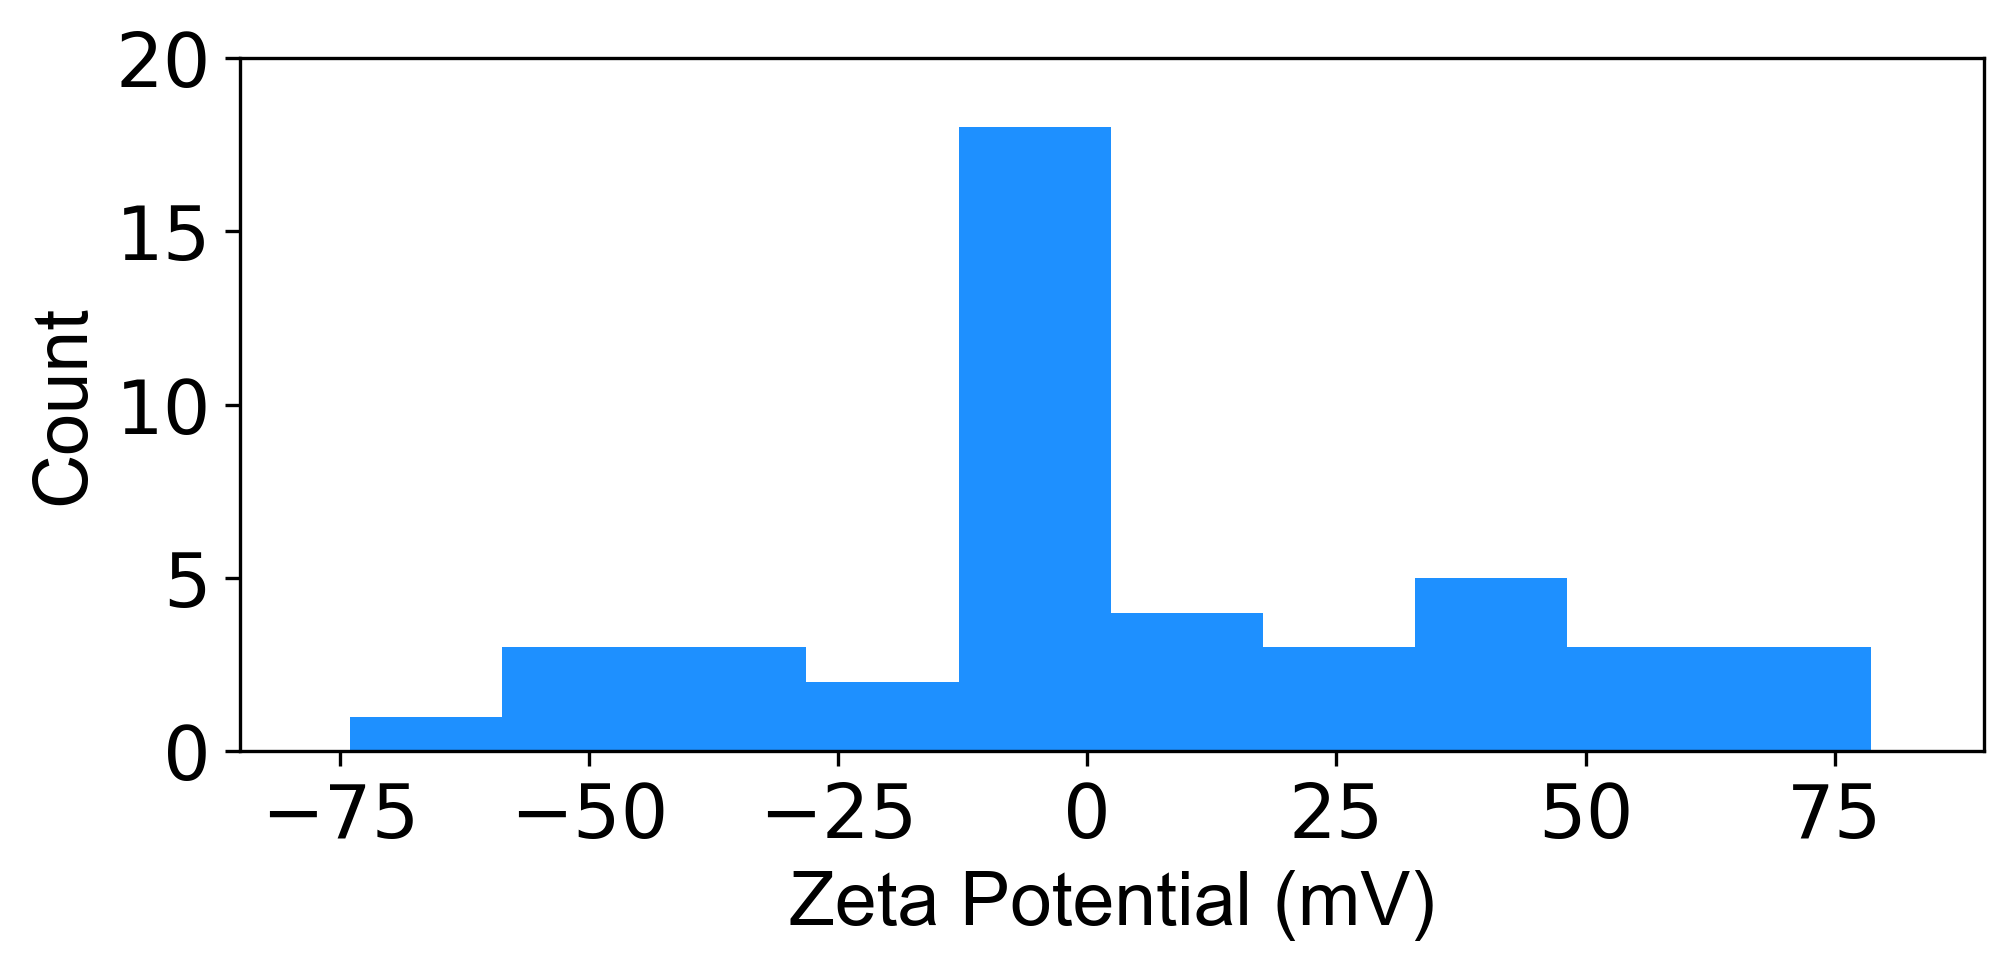

In [57]:
y_name = "Contact Angle"
number_of_bins = 10
    

val_scaled = pd.DataFrame(df_raw, columns=df_raw.columns)
#data_val = pd.concat([zeta, val_scaled], axis = 1).drop("index", axis=1)


plt.figure(figsize=(7.5, 3), dpi=300)
plt.rcParams['font.size'] = 18
plt.hist(zeta.iloc[:, 0], bins=number_of_bins, color="dodgerblue")
plt.xlabel("Zeta Potential (mV)", font="Arial")
plt.ylabel("Count", font="Arial")
plt.xlim(-85, 90)
plt.xticks(np.arange(-75, 100, 25))
plt.yticks(np.arange(0,25,5))
plt.show()

In [17]:
param_lasso = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_ridge = {"alpha": np.arange(0.05, 3., 0.01),
              "fit_intercept": [True, False]}

param_linear = {}

param_tree = {"max_depth": np.arange(1, 20),
             "min_samples_leaf": np.arange(1, 10, 1),
             "random_state": [42]}

param_forest = {"max_depth": np.arange(1, 20),
             "min_samples_leaf": np.arange(1, 10, 1),
             "n_estimators": [50, 100, 200, 300],
             "random_state": [42]}

param_knn = {"n_neighbors": np.arange(1, 10),
              "weights": ["uniform", "distance"]}

param_svr = {"C": [0.1, 1, 10, 100, 1000],
              "epsilon": [0.01, 0.1, 1, 10],
              "kernel": ["linear", "poly", "rbf", "sigmoid"]}

param_mlp = {"hidden_layer_sizes": [(50,), (100,), (150,),
                                    (50, 50), (100, 100), (150, 150),
                                    (50, 100), (50, 150), (100, 150),
                                    (50,50,50), (100,100,100), (150, 150, 150),
                                    (50, 100, 50), (50, 150, 50), (100, 100, 150), (100, 150, 100)],
             "activation": ["relu", "logistic", "tanh"],
             "solver": ["adam", "sgd"],
             "alpha": [0.0001, 0.001, 0.01],
             "learning_rate_init": [0.0001, 0.001, 0.01],
             "shuffle": [False],
             "max_iter": [1000]}

param_xgb = {"max_depth": np.arange(1, 20),
             "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3],
             "n_estimators": [50, 100, 150, 250, 500, 1000],
             "random_state": [42]}

models_param = {
    "Lasso": {"model": Lasso(), "param": param_lasso},
    "Ridge": {"model": Ridge(), "param": param_ridge},
    "Linear Regression": {"model": LinearRegression(), "param": param_linear},
    "Decision Tree": {"model": DecisionTreeRegressor(), "param": param_tree},
    "Random Forest": {"model": RandomForestRegressor(), "param": param_forest},
    "kNN": {"model": KNeighborsRegressor(), "param": param_knn},
    "SVR": {"model": SVR(), "param": param_svr},
    "MLP": {"model": MLPRegressor(), "param": param_mlp},
    "XGBoost": {"model": XGBRegressor(), "param": param_xgb}
}

optimized_models = {"Lasso":{"scores":[]},
                    "Ridge":{"scores":[]},
                    "Linear Regression":{"scores":[]},
                    "Decision Tree":{"scores":[]},
                    "Random Forest":{"scores":[]},
                    "kNN":{"scores":[]},
                    "SVR":{"scores":[]},
                    "MLP":{"scores":[]},
                    "XGBoost":{"scores":[]}}

outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)

In [18]:
for model_name, model_param in models_param.items():
    print("Training "+model_name+"...")
    model = model_param["model"]
    param = model_param["param"]
    best_para = []
    train_scores = []
    test_scores = []

    for train_idx, test_idx in outer_cv.split(X):
        X_train, y_train = X[train_idx], Y[train_idx]
        X_test, y_test = X[test_idx], Y[test_idx]
        
        grid = GridSearchCV(model, param, cv=inner_cv, n_jobs=-1, verbose=1)
        grid.fit(X_train, y_train)
        best_para.append(grid.best_params_)
        
        train_scores.append(grid.best_score_)
        
        model = grid.best_estimator_.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        r2_pred = r2_score(y_test, y_pred)
        test_scores.append(r2_pred)
    optimized_models[model_name]["best_para"] = best_para
    optimized_models[model_name]["train_scores"] = train_scores
    optimized_models[model_name]["test_scores"] = test_scores

    print("-------------------------NEXT-------------------------")

Training Lasso...
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
-------------------------NEXT-------------------------
Training Ridge...
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
Fitting 5 folds for each of 590 candidates, totalling 2950 fits
-------------------------NEXT-------------------------
Training Linear Regression...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 5 folds for each of 684 candidates, totalling 3420 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 5 folds for each of 684 candidates, totalling 3420 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 5 folds for each of 684 candidates, totalling 3420 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Fitting 5 folds for each of 684 candidates, totalling 3420 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


-------------------------NEXT-------------------------
Training kNN...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
-------------------------NEXT-------------------------
Training SVR...
Fitting 5 folds for each of 80 candidates, totalling 400 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


Fitting 5 folds for each of 80 candidates, totalling 400 fits


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


-------------------------NEXT-------------------------
Training MLP...
Fitting 5 folds for each of 864 candidates, totalling 4320 fits



36 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. Th

Fitting 5 folds for each of 864 candidates, totalling 4320 fits



26 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. Th

Fitting 5 folds for each of 864 candidates, totalling 4320 fits



43 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
43 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. Th

Fitting 5 folds for each of 864 candidates, totalling 4320 fits



59 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
59 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. Th

Fitting 5 folds for each of 864 candidates, totalling 4320 fits



48 fits failed out of a total of 4320.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 749, in fit
    return self._fit(X, y, incremental=False)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\ProgramData\anaconda3\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py", line 491, in _fit
    raise ValueError(
ValueError: Solver produced non-finite parameter weights. Th

-------------------------NEXT-------------------------
Training XGBoost...
Fitting 5 folds for each of 570 candidates, totalling 2850 fits
Fitting 5 folds for each of 570 candidates, totalling 2850 fits
Fitting 5 folds for each of 570 candidates, totalling 2850 fits
Fitting 5 folds for each of 570 candidates, totalling 2850 fits
Fitting 5 folds for each of 570 candidates, totalling 2850 fits
-------------------------NEXT-------------------------


In [19]:
optimized_models

{'Lasso': {'scores': [],
  'best_para': [{'alpha': 0.5200000000000001, 'fit_intercept': False},
   {'alpha': 0.11000000000000001, 'fit_intercept': False},
   {'alpha': 0.37000000000000005, 'fit_intercept': False},
   {'alpha': 0.8500000000000002, 'fit_intercept': False},
   {'alpha': 0.08000000000000002, 'fit_intercept': False}],
  'train_scores': [0.6554313756835145,
   0.63028795203716,
   0.10816032535022244,
   0.700454367600364,
   0.7023531895268089],
  'test_scores': [0.5958051221579084,
   0.6443829360642972,
   0.8028656669189389,
   0.42492272749096094,
   0.7086275544973963]},
 'Ridge': {'scores': [],
  'best_para': [{'alpha': 0.05, 'fit_intercept': False},
   {'alpha': 0.15000000000000002, 'fit_intercept': False},
   {'alpha': 0.27, 'fit_intercept': False},
   {'alpha': 0.26000000000000006, 'fit_intercept': False},
   {'alpha': 0.060000000000000005, 'fit_intercept': False}],
  'train_scores': [0.6442551818592068,
   0.6390815826778043,
   0.07206853475187117,
   0.691599546

In [59]:
optimized_models = {'Lasso': {'scores': [],
  'best_para': [{'alpha': 0.5200000000000001, 'fit_intercept': False},
   {'alpha': 0.11000000000000001, 'fit_intercept': False},
   {'alpha': 0.37000000000000005, 'fit_intercept': False},
   {'alpha': 0.8500000000000002, 'fit_intercept': False},
   {'alpha': 0.08000000000000002, 'fit_intercept': False}],
  'train_scores': [0.6554313756835145,
   0.63028795203716,
   0.10816032535022244,
   0.700454367600364,
   0.7023531895268089],
  'test_scores': [0.5958051221579084,
   0.6443829360642972,
   0.8028656669189389,
   0.42492272749096094,
   0.7086275544973963]},
 'Ridge': {'scores': [],
  'best_para': [{'alpha': 0.05, 'fit_intercept': False},
   {'alpha': 0.15000000000000002, 'fit_intercept': False},
   {'alpha': 0.27, 'fit_intercept': False},
   {'alpha': 0.26000000000000006, 'fit_intercept': False},
   {'alpha': 0.060000000000000005, 'fit_intercept': False}],
  'train_scores': [0.6442551818592068,
   0.6390815826778043,
   0.07206853475187117,
   0.6915995467291486,
   0.6991588546855899],
  'test_scores': [0.6017791023227813,
   0.6100897628390989,
   0.8261742596992894,
   0.39647339094670553,
   0.7066716006586112]},
 'Linear Regression': {'scores': [],
  'best_para': [{}, {}, {}, {}, {}],
  'train_scores': [0.25980276638461614,
   0.575493945114893,
   -0.6935428056534614,
   0.10537201577935443,
   0.6682783671795944],
  'test_scores': [0.5836043205032186,
   0.629995624036211,
   0.843048064363618,
   0.3041691968840009,
   0.7061213518306009]},
 'Decision Tree': {'scores': [],
  'best_para': [{'max_depth': 5, 'min_samples_leaf': 3, 'random_state': 42},
   {'max_depth': 2, 'min_samples_leaf': 1, 'random_state': 42},
   {'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 42},
   {'max_depth': 3, 'min_samples_leaf': 5, 'random_state': 42},
   {'max_depth': 3, 'min_samples_leaf': 1, 'random_state': 42}],
  'train_scores': [0.6911197468187613,
   0.6412115329665744,
   0.5490892406281184,
   0.7097021935353391,
   0.7805554142588969],
  'test_scores': [0.4808635453213991,
   0.5439525450694433,
   0.6064428551329741,
   0.5726014590467577,
   0.8108460494590696]},
 'Random Forest': {'scores': [],
  'best_para': [{'max_depth': 3,
    'min_samples_leaf': 1,
    'n_estimators': 200,
    'random_state': 42},
   {'max_depth': 2,
    'min_samples_leaf': 1,
    'n_estimators': 50,
    'random_state': 42},
   {'max_depth': 3,
    'min_samples_leaf': 1,
    'n_estimators': 100,
    'random_state': 42},
   {'max_depth': 4,
    'min_samples_leaf': 1,
    'n_estimators': 50,
    'random_state': 42},
   {'max_depth': 4,
    'min_samples_leaf': 1,
    'n_estimators': 100,
    'random_state': 42}],
  'train_scores': [0.7381674498032266,
   0.6699915459186487,
   0.3637212211296412,
   0.7696471166488491,
   0.7512613391353408],
  'test_scores': [0.6462538560547664,
   0.6057038489418917,
   0.7442155606938368,
   0.6937682505899398,
   0.8129452605960368]},
 'kNN': {'scores': [],
  'best_para': [{'n_neighbors': 8, 'weights': 'distance'},
   {'n_neighbors': 2, 'weights': 'uniform'},
   {'n_neighbors': 1, 'weights': 'uniform'},
   {'n_neighbors': 5, 'weights': 'distance'},
   {'n_neighbors': 2, 'weights': 'distance'}],
  'train_scores': [0.5111471479464096,
   0.6304189994580334,
   0.16861110008571664,
   0.6105473470536189,
   0.6578349130108561],
  'test_scores': [0.6026367729810571,
   0.476699618150211,
   0.8215806603244207,
   0.7636144193447701,
   0.6100376091819768]},
 'SVR': {'scores': [],
  'best_para': [{'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'},
   {'C': 100, 'epsilon': 0.01, 'kernel': 'linear'},
   {'C': 10, 'epsilon': 1, 'kernel': 'poly'},
   {'C': 100, 'epsilon': 1, 'kernel': 'linear'},
   {'C': 1000, 'epsilon': 10, 'kernel': 'linear'}],
  'train_scores': [0.5242382442035572,
   0.6761742470794029,
   0.1278645736956499,
   0.5959296980278597,
   0.737853972242891],
  'test_scores': [0.6035683997433257,
   0.4629242939643632,
   0.4053152493172263,
   0.08342917185533605,
   0.7256056375335416]},
 'MLP': {'scores': [],
  'best_para': [{'activation': 'relu',
    'alpha': 0.0001,
    'hidden_layer_sizes': (50, 50),
    'learning_rate_init': 0.01,
    'max_iter': 1000,
    'shuffle': False,
    'solver': 'adam'},
   {'activation': 'tanh',
    'alpha': 0.01,
    'hidden_layer_sizes': (50, 50, 50),
    'learning_rate_init': 0.001,
    'max_iter': 1000,
    'shuffle': False,
    'solver': 'adam'},
   {'activation': 'tanh',
    'alpha': 0.001,
    'hidden_layer_sizes': (50, 50),
    'learning_rate_init': 0.01,
    'max_iter': 1000,
    'shuffle': False,
    'solver': 'adam'},
   {'activation': 'logistic',
    'alpha': 0.01,
    'hidden_layer_sizes': (100, 100, 150),
    'learning_rate_init': 0.001,
    'max_iter': 1000,
    'shuffle': False,
    'solver': 'adam'},
   {'activation': 'tanh',
    'alpha': 0.001,
    'hidden_layer_sizes': (100, 100),
    'learning_rate_init': 0.001,
    'max_iter': 1000,
    'shuffle': False,
    'solver': 'adam'}],
  'train_scores': [0.659851730565088,
   0.7394631798982363,
   0.4075123485515134,
   0.779228968507933,
   0.7709525281624805],
  'test_scores': [0.3802529444961249,
   0.6357882519174549,
   0.851280602129243,
   0.23514261107765622,
   0.8459205474568456]},
 'XGBoost': {'scores': [],
  'best_para': [{'learning_rate': 0.05,
    'max_depth': 2,
    'n_estimators': 150,
    'random_state': 42},
   {'learning_rate': 0.1,
    'max_depth': 1,
    'n_estimators': 50,
    'random_state': 42},
   {'learning_rate': 0.01,
    'max_depth': 8,
    'n_estimators': 250,
    'random_state': 42},
   {'learning_rate': 0.05,
    'max_depth': 1,
    'n_estimators': 100,
    'random_state': 42},
   {'learning_rate': 0.05,
    'max_depth': 2,
    'n_estimators': 1000,
    'random_state': 42}],
  'train_scores': [0.7163350094242851,
   0.7520631728451601,
   0.5353819188661175,
   0.794913491734162,
   0.7924926010990974],
  'test_scores': [0.7039956844051914,
   0.5848960062242612,
   0.5915827500194685,
   0.49753335454476866,
   0.7817862520920189]}}

In [23]:
#split validation set
train_set, validation_set = train_test_split(dataset, test_size=0.2, random_state=42)

#training set
X_part = train_set.drop("Zeta potential / mV", axis=1)
Y_part = train_set["Zeta potential / mV"].copy()
X_part_array = np.array(X_part)
Y_part_array = np.array(Y_part)

#validation set
X_val = validation_set.drop("Zeta potential / mV", axis=1)
Y_val = validation_set["Zeta potential / mV"].copy()
X_val_array = np.array(X_val)
Y_val_array = np.array(Y_val)

In [60]:
def gen_fig1(model_name, X_train, Y_train, X_val, Y_val, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions):

    model_name = str(model_name)
    fig,ax=plt.subplots(figsize=(6, 6))
    Axis_line=np.linspace(*ax.get_xlim(),2)
    ax.plot(Axis_line,Axis_line,transform=ax.transAxes,linestyle='--',
            linewidth=2,color='black',label="1:1 Line")
    ax.set_xlim([-85, 125])
    ax.set_ylim([-85, 125])
    
    rmse_train_mean = round(np.mean(rmse_train, axis=0), 2)
    rmse_val_mean = round(np.mean(rmse_val, axis=0), 2)
    rmse_train_std = round(np.std(rmse_train, axis=0), 2)
    rmse_val_std = round(np.std(rmse_val, axis=0), 2)
    r2_train_mean = round(np.mean(r2_train, axis=0), 2)
    r2_val_mean = round(np.mean(r2_val, axis=0), 2)
    r2_train_std = round(np.std(r2_train, axis=0), 2)
    r2_val_std = round(np.std(r2_val, axis=0), 2)
    
    scatter1 = ax.scatter(X_train, Y_train, color='salmon', alpha=0.5, label="Training set")
    plt1 = ax.errorbar(X_train, Y_train, yerr=std_part_predictions, fmt="none", color='r', alpha=0.5)
    scatter2 = ax.scatter(X_val, Y_val, color='steelblue', label="Test set")
    plt2 = ax.errorbar(X_val, Y_val, yerr=std_predictions, fmt='none', color='b', alpha=0.5)
    plt.legend(handles=[scatter1, scatter2], labels = ["Training set", "Test set"], loc="lower right", fontsize=14, fancybox=True, markerscale=0.8, framealpha=0.8, handlelength=0.5)

    ax.text(5, 190, " Score of "+model_name+" "
            "\n $RMSE$ (training): "+str(rmse_train_mean)+" ± "+str(rmse_train_std)+" "
            "\n $RMSE$ (test): "+str(rmse_val_mean)+" ± "+str(rmse_val_std)+" "
            "\n $R\u00b2$ (training): "+str(r2_train_mean)+" ± "+str(r2_train_std)+" "
            "\n $R\u00b2$ (test): "+str(r2_val_mean)+" ± "+str(r2_val_std)+" ",
            verticalalignment='top', horizontalalignment='left',fontsize=16,
            bbox={'facecolor': 'lightskyblue', 'alpha': 0.2, 'pad': 1})

    plt.xlabel("Reported ZP", fontsize=20, fontweight='bold', font="Arial")
    plt.ylabel("Predicted ZP", fontsize=20, fontweight='bold', font="Arial")
    new_ticks = np.linspace(-75, 125, 9)
    new_ticks = [-50, -25, 0, 25, 50, 75, 100, 125]
    plt.xticks(new_ticks, fontweight='bold')
    plt.yticks(new_ticks, fontweight='bold')
    ax.tick_params(labelsize="16", direction="in")

    plt.rcParams['axes.titley'] = 1.03
    plt.title(model_name, fontsize=26,fontweight='bold',font="Arial", color='black')
            
    plt.show()
    plt.clf()

In [61]:
def gen_fig(model_name, X_train, Y_train, X_val, Y_val, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions):

    model_name = str(model_name)
    fig,ax=plt.subplots(figsize=(6, 6))
    Axis_line=np.linspace(*ax.get_xlim(),2)
    ax.plot(Axis_line,Axis_line,transform=ax.transAxes,linestyle='--',
            linewidth=2,color='black',label="1:1 Line")
    ax.set_xlim([-85, 125])
    ax.set_ylim([-85, 125])
    
    rmse_train_mean = round(np.mean(rmse_train, axis=0), 2)
    rmse_val_mean = round(np.mean(rmse_val, axis=0), 2)
    rmse_train_std = round(np.std(rmse_train, axis=0), 2)
    rmse_val_std = round(np.std(rmse_val, axis=0), 2)
    r2_train_mean = round(np.mean(r2_train, axis=0), 2)
    r2_val_mean = round(np.mean(r2_val, axis=0), 2)
    r2_train_std = round(np.std(r2_train, axis=0), 2)
    r2_val_std = round(np.std(r2_val, axis=0), 2)
    
    scatter1 = ax.scatter(X_train, Y_train, color='salmon', alpha=0.5, label="Training set")
    plt1 = ax.errorbar(X_train, Y_train, yerr=std_part_predictions, fmt="none", color='r', alpha=0.5)
    scatter2 = ax.scatter(X_val, Y_val, color='steelblue', label="Test set")
    plt2 = ax.errorbar(X_val, Y_val, yerr=std_predictions, fmt='none', color='b', alpha=0.5)
    plt.legend(handles=[scatter1, scatter2], labels = ["Training set", "Test set"], loc="lower right", fontsize=14, fancybox=True, markerscale=0.8, framealpha=0.8, handlelength=0.5)

    ax.text(-80, 120, " Score of "+model_name+" "
            "\n $RMSE$ (training): "+str(rmse_train_mean)+" ± "+str(rmse_train_std)+" "
            "\n $RMSE$ (test): "+str(rmse_val_mean)+" ± "+str(rmse_val_std)+" "
            "\n $R\u00b2$ (training): "+str(r2_train_mean)+" ± "+str(r2_train_std)+" "
            "\n $R\u00b2$ (test): "+str(r2_val_mean)+" ± "+str(r2_val_std)+" ",
            verticalalignment='top', horizontalalignment='left',fontsize=16,
            bbox={'facecolor': 'lightskyblue', 'alpha': 0.2, 'pad': 1})

    plt.xlabel("Reported ZP (mV)", fontsize=20, fontweight='bold', font="Arial")
    plt.ylabel("Predicted ZP (mV)", fontsize=20, fontweight='bold', font="Arial")
    new_ticks = [-75, -50, -25, 0, 25, 50, 75, 100, 125]
    plt.xticks(new_ticks, fontweight='bold')
    plt.yticks(new_ticks, fontweight='bold')
    ax.tick_params(labelsize="16", direction="in")

    plt.rcParams['axes.titley'] = 1.03
    plt.title(model_name, fontsize=26,fontweight='bold',font="Arial", color='black')
            
    plt.show()
    plt.clf()

   
def result_show(model, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    
    model.fit(X_part_array, Y_part_array)
    Y_predict = model.predict(X_val_array)
    Y_part_predict = model.predict(X_part_array)
    
    RMSE_val = np.sqrt(mean_squared_error(Y_val_array, Y_predict))
    RMSE_train = np.sqrt(mean_squared_error(Y_part_array, Y_part_predict))
    # sns.distplot(Y_predict-Y_val_array)
    r2_train = r2_score(Y_part_array, Y_part_predict)
    r2_test = r2_score(Y_val_array, Y_predict)  
        
    gen_fig1(model_name, Y_part_array, Y_part_predict, Y_val_array, Y_predict, RMSE_train, RMSE_val, r2_train, r2_test)
    
    return model

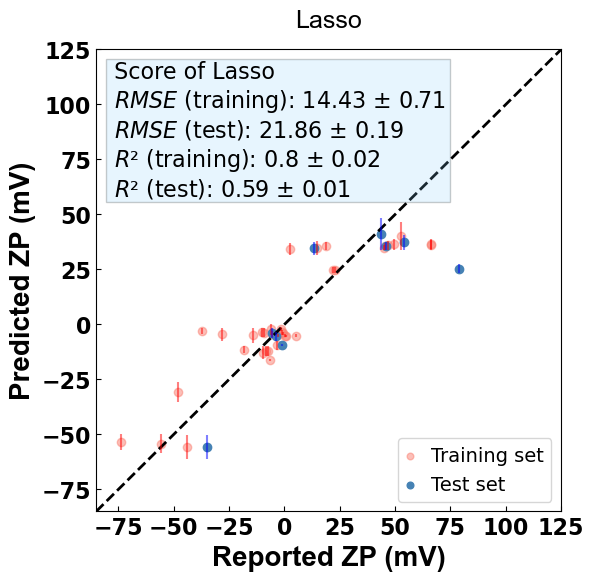

<Figure size 640x480 with 0 Axes>

In [26]:
def result_lasso(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = Lasso(**optimized_models["Lasso"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))       

    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)

    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_lasso(optimized_models, "Lasso", X_part_array, Y_part_array, X_val_array, Y_val_array)


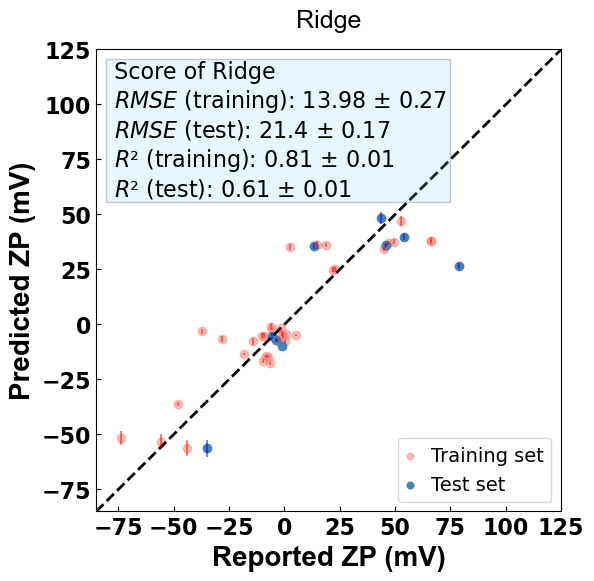

<Figure size 640x480 with 0 Axes>

In [27]:
def result_ridge(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = Ridge(**optimized_models["Ridge"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))     
        
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)

    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_ridge(optimized_models, "Ridge", X_part_array, Y_part_array, X_val_array, Y_val_array)

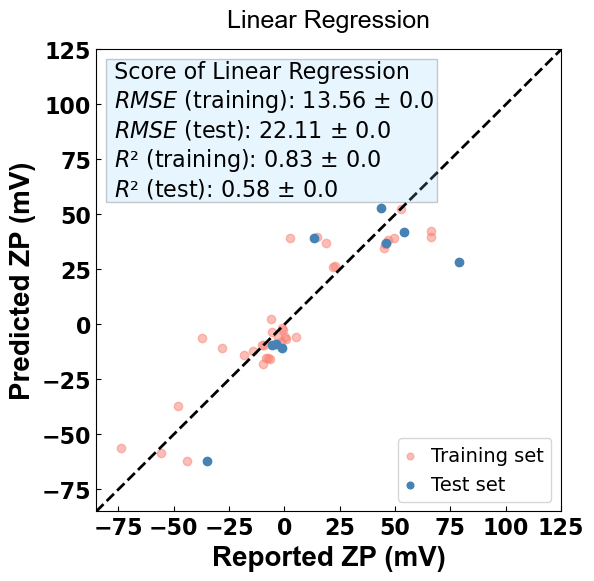

<Figure size 640x480 with 0 Axes>

In [28]:
def result_linear(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = LinearRegression(**optimized_models["Linear Regression"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)

    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_linear(optimized_models, "Linear Regression", X_part_array, Y_part_array, X_val_array, Y_val_array)

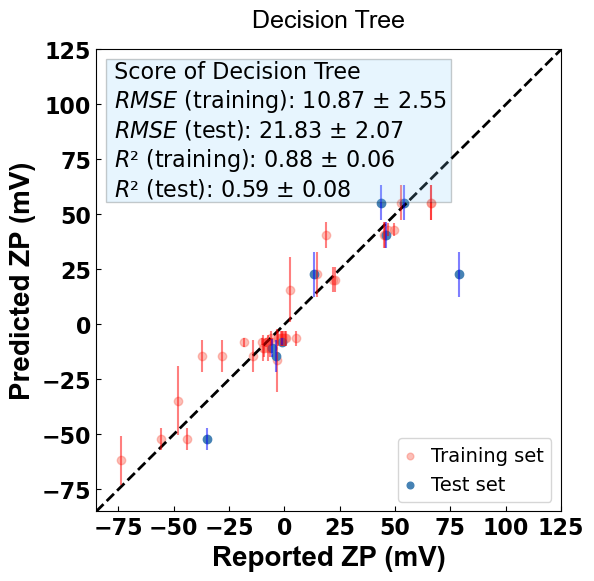

<Figure size 640x480 with 0 Axes>

In [29]:
def result_tree(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = DecisionTreeRegressor(**optimized_models["Decision Tree"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_tree(optimized_models, "Decision Tree", X_part_array, Y_part_array, X_val_array, Y_val_array)

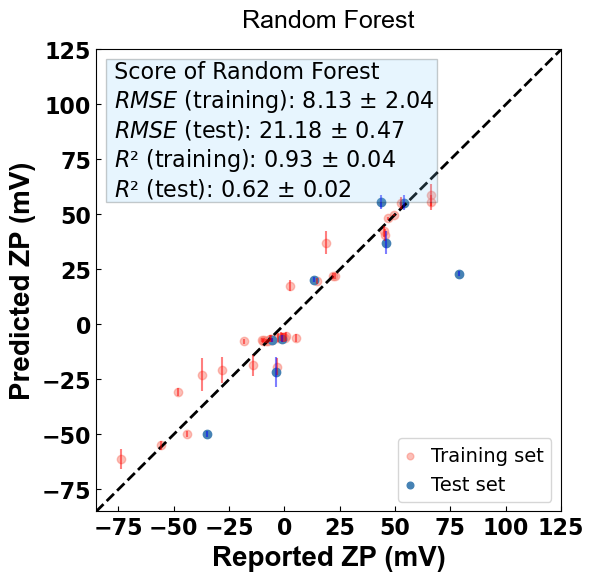

<Figure size 640x480 with 0 Axes>

In [30]:
def result_forest(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = RandomForestRegressor(**optimized_models["Random Forest"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_forest(optimized_models, "Random Forest", X_part_array, Y_part_array, X_val_array, Y_val_array)

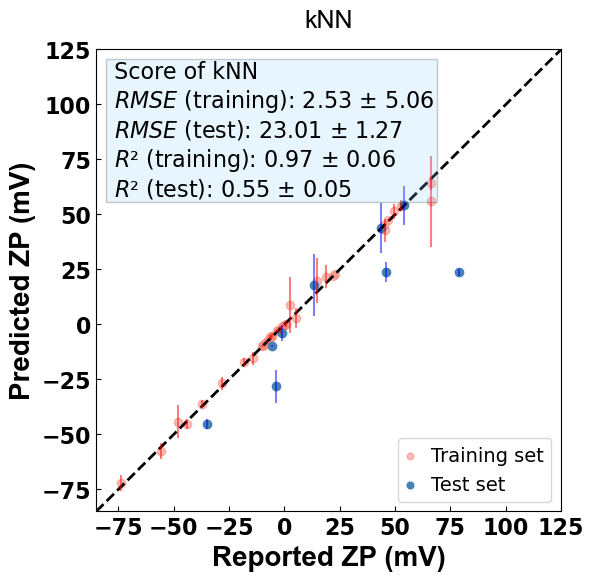

<Figure size 640x480 with 0 Axes>

In [31]:
def result_knn(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = KNeighborsRegressor(**optimized_models["kNN"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)

result_knn(optimized_models, "kNN", X_part_array, Y_part_array, X_val_array, Y_val_array)

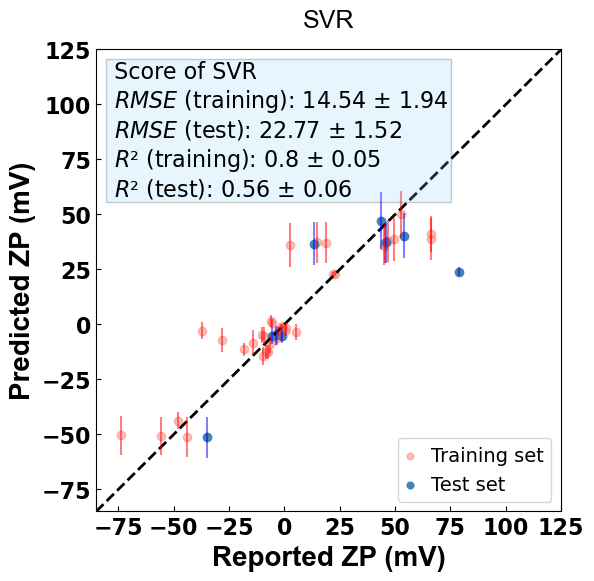

<Figure size 640x480 with 0 Axes>

In [32]:
def result_svr(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = SVR(**optimized_models["SVR"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    return model
    
svr = result_svr(optimized_models, "SVR", X_part_array, Y_part_array, X_val_array, Y_val_array)

Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.


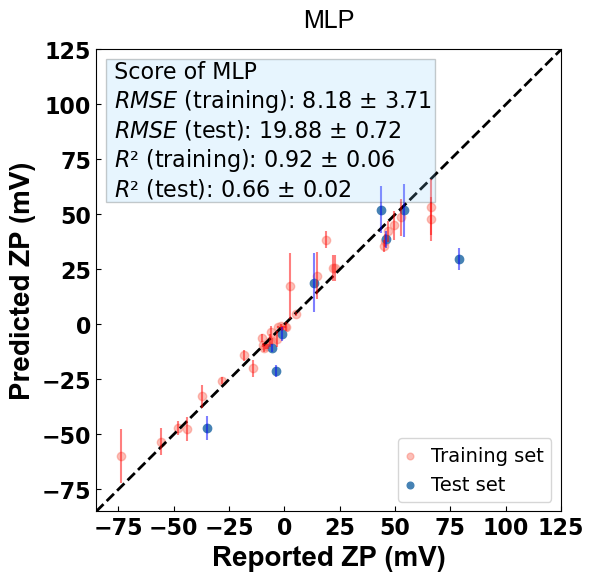

<Figure size 640x480 with 0 Axes>

In [33]:
def result_mlp(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    for i in range(5):
        model = MLPRegressor(**optimized_models["MLP"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    
result_mlp(optimized_models, "MLP", X_part_array, Y_part_array, X_val_array, Y_val_array)

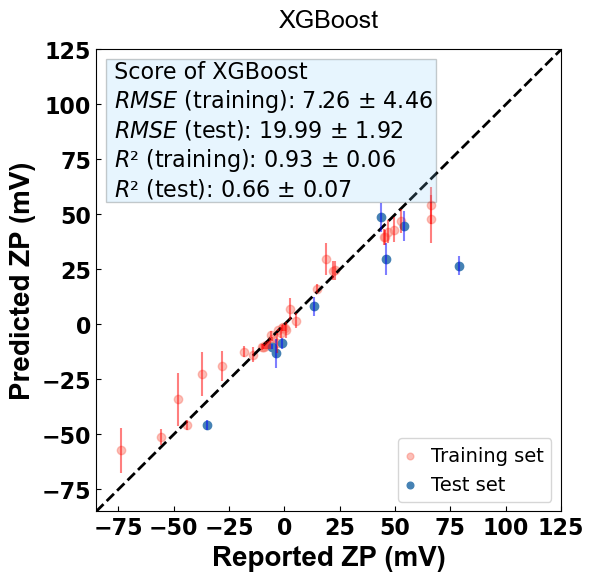

<Figure size 640x480 with 0 Axes>

In [65]:
def result_xgb(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    models = []
    for i in range(5):
        model = XGBRegressor(**optimized_models["XGBoost"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
        r2_val.append(r2_score(Y_val_array, y_pred))
        models.append(model)   
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    return model
    
xgb_model = result_xgb(optimized_models, "XGBoost", X_part_array, Y_part_array, X_val_array, Y_val_array)

In [35]:
test_scores = ["Lasso: " + str(round(mean(optimized_models["Lasso"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Lasso"]["test_scores"]), 2)) + ")",
            "Ridge: " + str(round(mean(optimized_models["Ridge"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Ridge"]["test_scores"]), 2)) + ")",
            "Linear Regression: " + str(round(mean(optimized_models["Linear Regression"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Linear Regression"]["test_scores"]), 2)) + ")",
            "Decision Tree: " + str(round(mean(optimized_models["Decision Tree"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Decision Tree"]["test_scores"]), 2)) + ")",
            "Random Forest: " + str(round(mean(optimized_models["Random Forest"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Random Forest"]["test_scores"]), 2)) + ")",
            "kNN: " + str(round(mean(optimized_models["kNN"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["kNN"]["test_scores"]), 2)) + ")",
            "SVR: " + str(round(mean(optimized_models["SVR"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["SVR"]["test_scores"]), 2)) + ")",
            "MLP: " + str(round(mean(optimized_models["MLP"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["MLP"]["test_scores"]), 2)) + ")",
            "XGBoost: " + str(round(mean(optimized_models["XGBoost"]["test_scores"]), 2)) + " (" + str(round(stdev(optimized_models["XGBoost"]["test_scores"]), 2)) + ")"]
test_scores

['Lasso: 0.64 (0.14)',
 'Ridge: 0.63 (0.16)',
 'Linear Regression: 0.61 (0.2)',
 'Decision Tree: 0.6 (0.13)',
 'Random Forest: 0.7 (0.08)',
 'kNN: 0.65 (0.14)',
 'SVR: 0.46 (0.24)',
 'MLP: 0.59 (0.28)',
 'XGBoost: 0.63 (0.11)']

In [36]:
train_scores = ["Lasso: " + str(round(mean(optimized_models["Lasso"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Lasso"]["train_scores"]), 2)) + ")",
            "Ridge: " + str(round(mean(optimized_models["Ridge"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Ridge"]["train_scores"]), 2)) + ")",
            "Linear Regression: " + str(round(mean(optimized_models["Linear Regression"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Linear Regression"]["train_scores"]), 2)) + ")",
            "Decision Tree: " + str(round(mean(optimized_models["Decision Tree"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Decision Tree"]["train_scores"]), 2)) + ")",
            "Random Forest: " + str(round(mean(optimized_models["Random Forest"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["Random Forest"]["train_scores"]), 2)) + ")",
            "kNN: " + str(round(mean(optimized_models["kNN"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["kNN"]["train_scores"]), 2)) + ")",
            "SVR: " + str(round(mean(optimized_models["SVR"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["SVR"]["train_scores"]), 2)) + ")",
            "MLP: " + str(round(mean(optimized_models["MLP"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["MLP"]["train_scores"]), 2)) + ")",
            "XGBoost: " + str(round(mean(optimized_models["XGBoost"]["train_scores"]), 2)) + " (" + str(round(stdev(optimized_models["XGBoost"]["train_scores"]), 2)) + ")"]
train_scores

['Lasso: 0.56 (0.25)',
 'Ridge: 0.55 (0.27)',
 'Linear Regression: 0.18 (0.54)',
 'Decision Tree: 0.67 (0.09)',
 'Random Forest: 0.66 (0.17)',
 'kNN: 0.52 (0.2)',
 'SVR: 0.53 (0.24)',
 'MLP: 0.67 (0.15)',
 'XGBoost: 0.72 (0.11)']

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


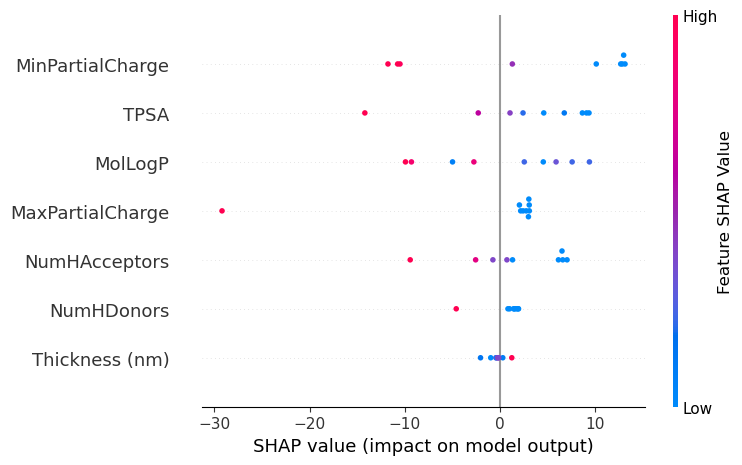

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


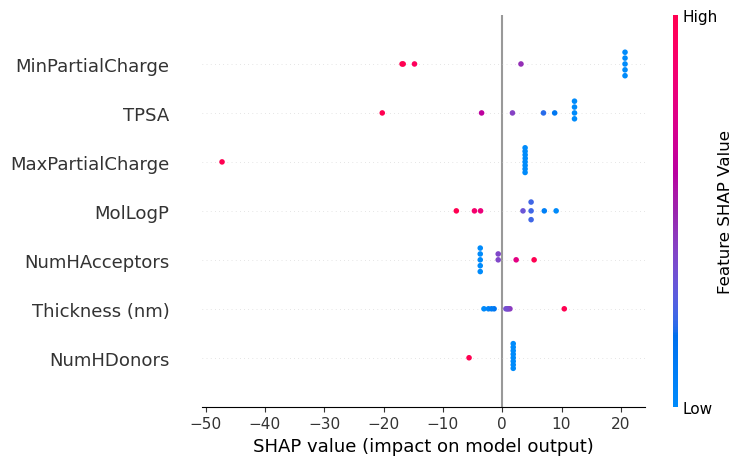

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


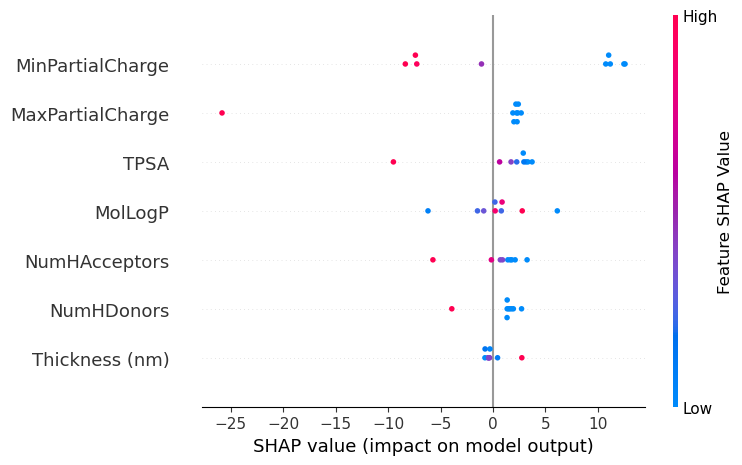

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


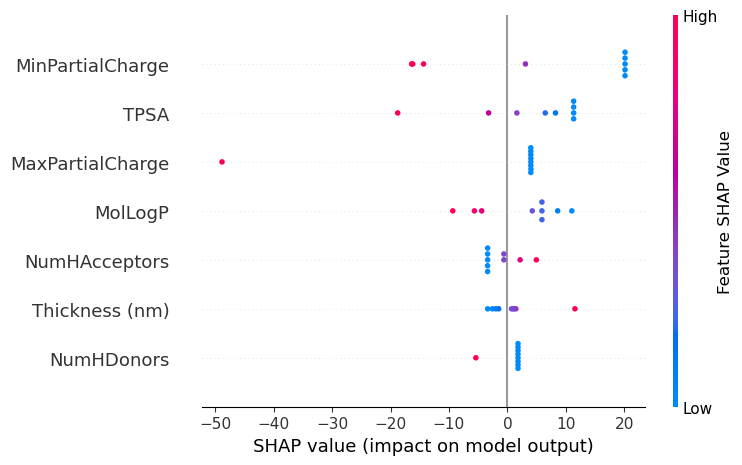

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


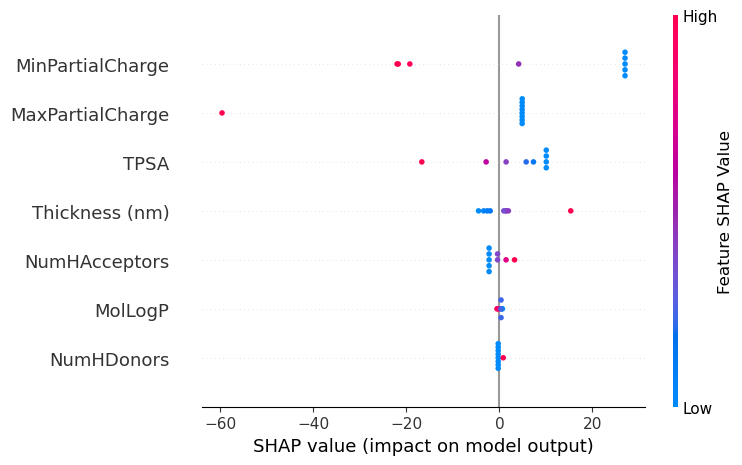

In [37]:
def result_svr(optimized_models, model_name, X_part_array, Y_part_array, X_val_array, Y_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    for i in range(5):
        model = SVR(**optimized_models["SVR"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part__pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part__pred)
        all_y_predictions.append(y_pred)
        explainer = shap.KernelExplainer(model.predict, X_part_array)
        shap_values = explainer.shap_values(X_val_array)

        
        shap.summary_plot(shap_values, X_val_array, feature_names=X_part.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)
        plt.show()
        
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    rmse_val = np.sqrt(mean_squared_error(Y_val_array, mean_predictions))
    rmse_train = np.sqrt(mean_squared_error(Y_part_array, mean_part_predictions))
    r2_train = r2_score(Y_part_array, mean_part_predictions)
    r2_val = r2_score(Y_val_array, mean_predictions)
    #gen_fig(model_name, Y_part_array, mean_part_predictions, Y_val_array, mean_predictions, rmse_train, rmse_val, r2_train, r2_val, std_part_predictions, std_predictions)
    #return model
    
result_svr(optimized_models, "SVR", X_part_array, Y_part_array, X_val_array, Y_val_array)

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


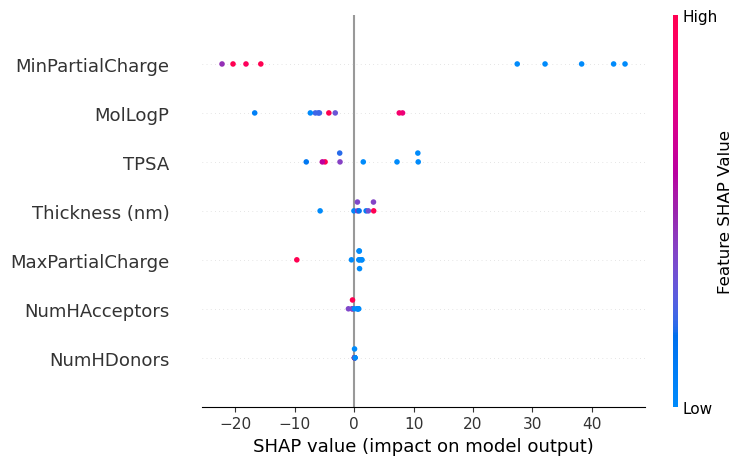

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


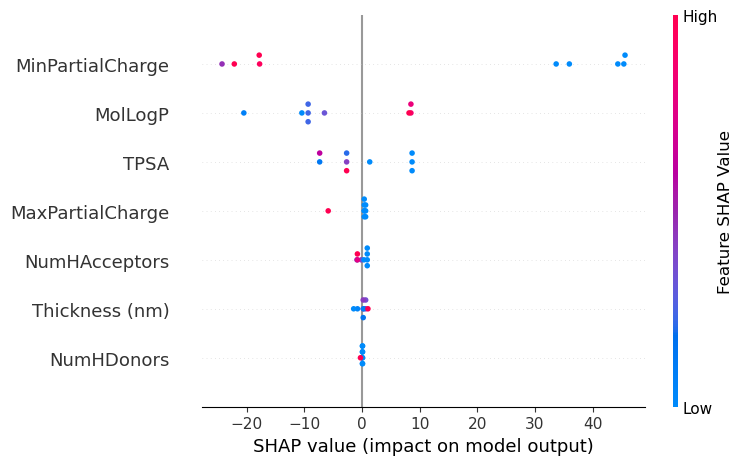

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


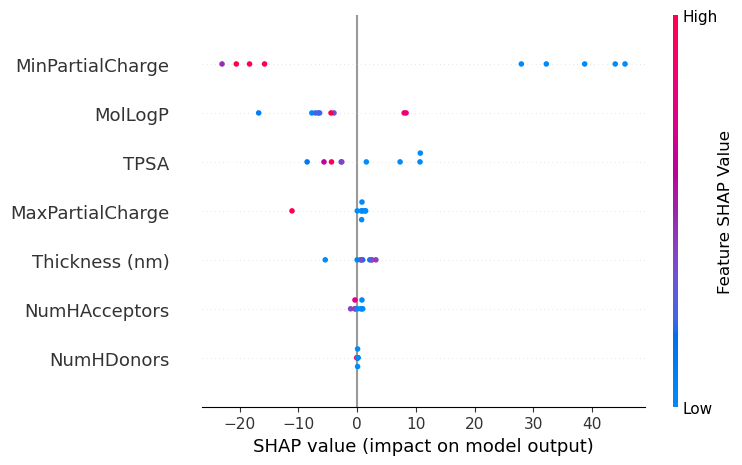

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


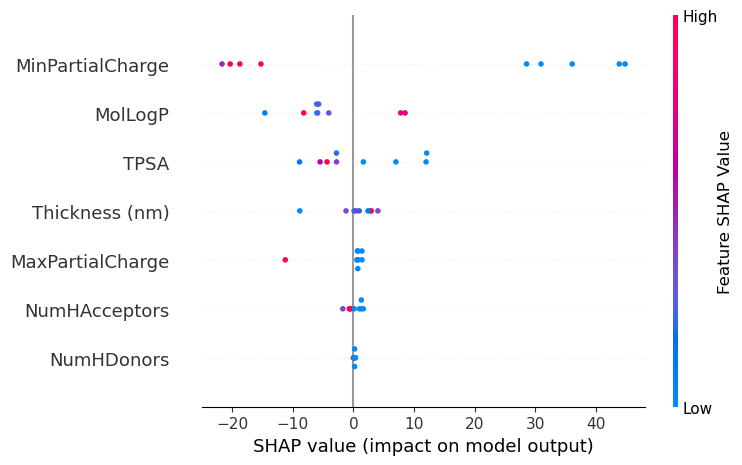

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


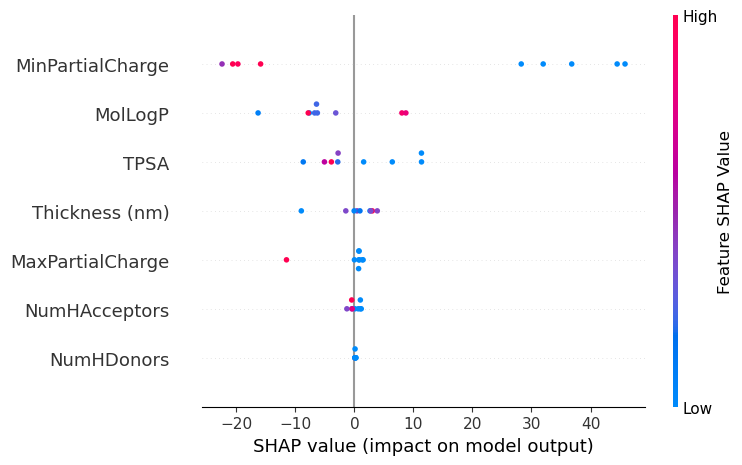

In [38]:
def result_forest(optimized_models, X_part_array, Y_part_array, X_val_array):
    #all_y_predictions = []
    #all_y_part_predictions = []
    for i in range(5):
        model = RandomForestRegressor(**optimized_models["Random Forest"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        #y_part__pred = model.predict(X_part_array)
        #y_pred = model.predict(X_val_array)
        #all_y_part_predictions.append(y_part__pred)
        #all_y_predictions.append(y_pred)
        explainer = shap.KernelExplainer(model.predict, X_part_array)
        shap_values = explainer.shap_values(X_val_array)

        shap.summary_plot(shap_values, X_val_array, feature_names=X_part.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)
        plt.show()
        
    
result_forest(optimized_models, X_part_array, Y_part_array, X_val_array)

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


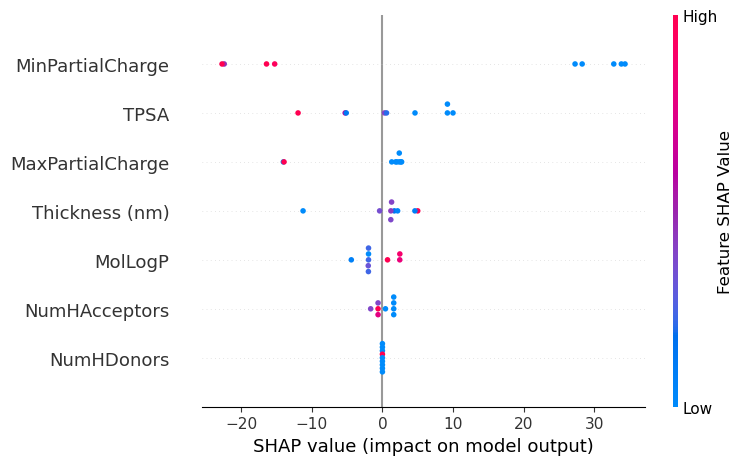

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


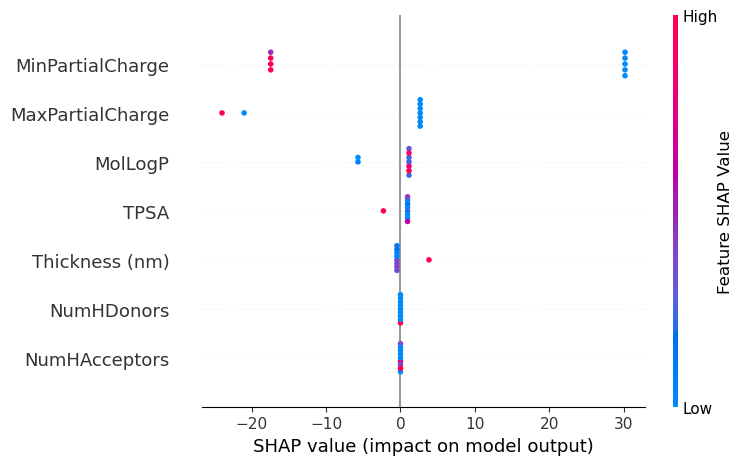

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


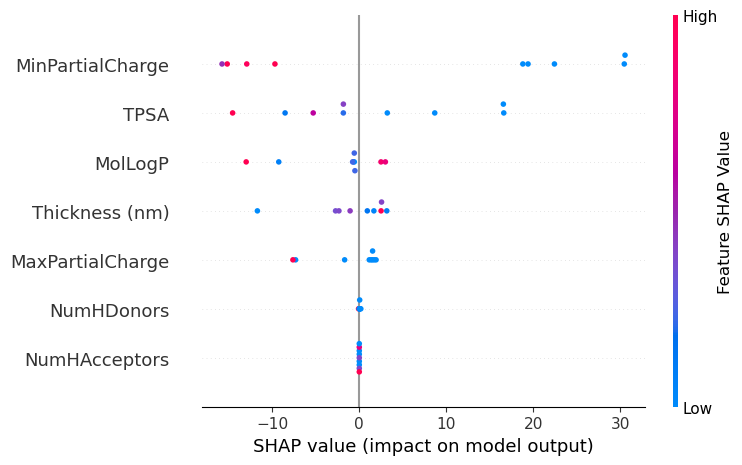

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


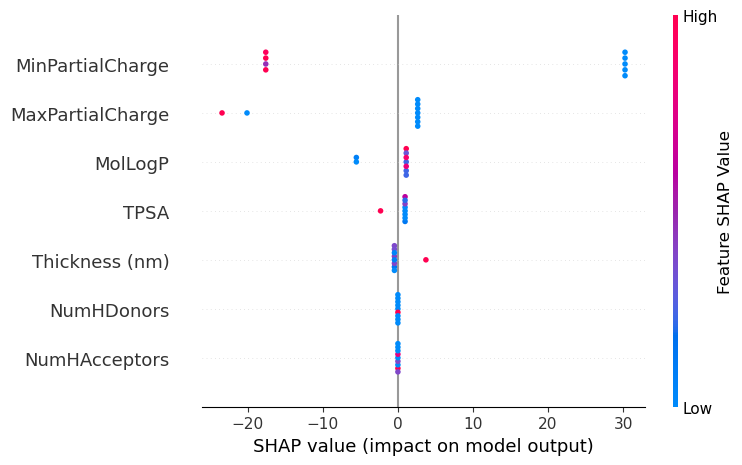

  0%|          | 0/9 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


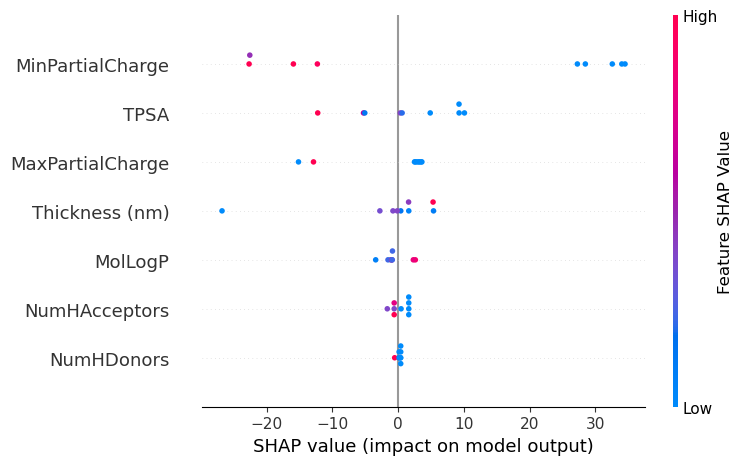

In [42]:
def result_xgb(optimized_models, X_part_array, Y_part_array, X_val_array):
    #all_y_predictions = []
    #all_y_part_predictions = []
    for i in range(5):
        model = XGBRegressor(**optimized_models["XGBoost"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        #y_part__pred = model.predict(X_part_array)
        #y_pred = model.predict(X_val_array)
        #all_y_part_predictions.append(y_part__pred)
        #all_y_predictions.append(y_pred)
        explainer = shap.KernelExplainer(model.predict, X_part_array)
        shap_values = explainer.shap_values(X_val_array)

        shap.summary_plot(shap_values, X_val_array, feature_names=X_part.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)
        plt.show()
        
    
result_xgb(optimized_models, X_part_array, Y_part_array, X_val_array)

In [41]:
explainer = shap.TreeExplainer(model=optimized_models["XGBoost"]["best_para"][0],
                                feature_perturbation='tree_path_dependent',
                                model_output='margin')
shap_values = explainer.shap_values(X_val_array)
shap.summary_plot(shap_values, X_val_array, feature_names=X_part.columns.values, plot_size=(8,5), color_bar_label="Feature SHAP Value", auto_size_plot=None)


model_output = "margin" has been renamed to model_output = "raw"


InvalidModelError: Model type not yet supported by TreeExplainer: <class 'dict'>

In [73]:
bsa = pd.read_csv("240627BSA_selected_descriptors.csv")
bsa

,Thickness (nm),MaxPartialCharge,MinPartialCharge,TPSA,NumHAcceptors,NumHDonors,MolLogP
0,11.962000,0.332603,-0.462355,26.30,2,0,1.9058
1,16.822000,0.332687,-0.459910,46.53,3,1,0.0980
2,17.900000,0.332687,-0.459899,63.22,6,0,0.8019
3,19.788958,0.329722,-0.460091,35.53,3,0,0.3620
4,9.222500,0.332820,-1.000000,53.94,2,1,-3.6484
5,19.387333,0.332820,-0.549934,66.43,4,0,-0.6779
6,12.490000,0.332688,-0.756117,84.89,6,0,0.3135
7,18.930000,1.000000,-0.747942,83.50,5,0,-2.9550
8,7.300000,0.332820,-1.000000,26.30,2,0,-2.1841
9,11.800000,0.332820,-1.000000,26.30,2,0,-2.1841


In [75]:

bsa_scaled = max_abs_scaler.transform(bsa)
descriptors_bsa = pd.DataFrame(bsa_scaled, columns=bsa.columns)


X_bsa = np.array(descriptors_bsa)


In [78]:
def predict_xgb(optimized_models, model_name, X_part_array, Y_part_array, X_val_array):
    all_y_predictions = []
    all_y_part_predictions = []
    rmse_train = []
    rmse_val = []
    r2_train = []
    r2_val = []
    

    for i in range(5):
        model = XGBRegressor(**optimized_models["XGBoost"]["best_para"][i])
        model.fit(X_part_array, Y_part_array)
        y_part_pred = model.predict(X_part_array)
        y_pred = model.predict(X_val_array)
        all_y_part_predictions.append(y_part_pred)
        all_y_predictions.append(y_pred)
        rmse_train.append(np.sqrt(mean_squared_error(Y_part_array, y_part_pred)))
        #rmse_val.append(np.sqrt(mean_squared_error(Y_val_array, y_pred)))
        r2_train.append(r2_score(Y_part_array, y_part_pred))
       # r2_val.append(r2_score(Y_val_array, y_pred))
 
    mean_part_predictions = np.mean(all_y_part_predictions, axis=0)
    std_part_predictions = np.std(all_y_part_predictions, axis=0)
    mean_predictions = np.mean(all_y_predictions, axis=0)
    std_predictions = np.std(all_y_predictions, axis=0)
    #gen_fig(model_name, Y_part_array, mean_part_predictions, mean_predictions, rmse_train, r2_train, std_part_predictions, std_predictions)
    df = pd.DataFrame(mean_predictions)
    df.to_csv(model_name+"_predictions.csv")


predict_xgb(optimized_models, "XGBoost_BSA", X_part_array, Y_part_array, X_bsa)

In [79]:
lys = pd.read_csv("240627Lys_selected_descriptors.csv")

lys_scaled = max_abs_scaler.transform(lys)
descriptors_lys = pd.DataFrame(lys_scaled, columns=lys.columns)


X_lys = np.array(descriptors_lys)

predict_xgb(optimized_models, "XGBoost_Lys", X_part_array, Y_part_array, X_lys)

In [ ]:
lys = pd.read_csv("240627Lys_selected_descriptors.csv")

lys_scaled = max_abs_scaler.transform(lys)
descriptors_lys = pd.DataFrame(lys_scaled, columns=lys.columns)


X_lys = np.array(descriptors_lys)

predict_xgb(optimized_models, "XGBoost_Lys", X_part_array, Y_part_array, X_lys)

In [80]:


all_p = pd.read_csv("240628All_selected_descriptors.csv")

all_p_scaled = max_abs_scaler.transform(all_p)
descriptors_all = pd.DataFrame(all_p_scaled, columns=all_p.columns)


X_all = np.array(descriptors_all)

predict_xgb(optimized_models, "XGBoost_All", X_part_array, Y_part_array, X_all)